In [59]:
# General imports
import numpy as np
import pandas as pd

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize

# Visualization
import rustworkx as rx
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import math

In [67]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.get_backend("ibmq_qasm_simulator")
backend.name

qiskit_runtime_service.__init__:INFO:2024-02-04 01:12:17,517: Default instance: ibm-q/open/main


'ibmq_qasm_simulator'

In [65]:
# Sample data
patients = [
    {'type': 'patient', 'name': 'Alice', 'blood_type': 'A', 'organ': 'heart', 'age': 20, 'location': (10, 20), 'health': 5},
    {'type': 'patient', 'name': 'Sarah', 'blood_type': 'B', 'organ': 'kidney', 'age': 70, 'location': (20, 40), 'health': 4},
    {'type': 'patient', 'name': 'Cindy', 'blood_type': 'AB', 'organ': 'heart', 'age': 60, 'location': (40, 30), 'health': 2}
]

donors = [
    {'type': 'donor', 'name': 'Lana', 'blood_type': 'O', 'organ': 'heart', 'age': 30, 'location': (30, 10), 'health': 2},
    {'type': 'donor', 'name': 'Megan', 'blood_type': 'A', 'organ': 'heart', 'age': 40, 'location': (10, 20), 'health': 4},
    {'type': 'donor', 'name': 'Maya', 'blood_type': 'B', 'organ': 'kidney', 'age': 50, 'location': (40, 50), 'health': 1}
]

In [66]:
# Weight in compatibility

def blood_type(patient, donor):
    if patient['blood_type'] == donor['blood_type']:
        score = 1.0
    elif patient['blood_type'] == 'O' or donor['blood_type'] == 'O':
        score = 0.7
    elif (patient['blood_type'] == 'A' and donor['blood_type'] == 'B') or (patient['blood_type'] == 'B' and donor['blood_type'] == 'A'):
        score = 0.9
    elif (patient['blood_type'] in ('A', 'B') and donor['blood_type'] == 'AB') or (patient['blood_type'] == 'AB' and donor['blood_type'] in ('A', 'B')):
        score = 0.8
    else:
        score = 0
            
    return score

def organ(patient, donor):
    if patient['organ'] == donor['organ']:
        return 1
    else:
        return 0
    
def age(patient, donor):
    d_age = abs(patient['age'] - donor['age'])
    return max(0, 1.0 - 0.01 * d_age)

def health(patient, donor):
    return min(1.0, 0.1 * (patient['health'] + donor['health']))
    
def distance(patient, donor):
    loc1 = patient['location']
    loc2 = donor['location']
    
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

def compatibility(patient, donor):
    return min(blood_type(patient, donor), organ(patient, donor),
               blood_type(patient, donor) + organ(patient, donor) + age(patient, donor) + health(patient, donor) + distance(patient, donor))

compatibility_scores = {}

for patient in patients:
    for donor in donors:
        key = (patient['name'], donor['name'])
        compatibility_scores[key] = compatibility(patient, donor)

for key, score in compatibility_scores.items():
    print(f"Compatibility between {key[0]} and {key[1]}: {score}")

Compatibility between Alice and Lana: 0.7
Compatibility between Alice and Megan: 1.0
Compatibility between Alice and Maya: 0
Compatibility between Sarah and Lana: 0
Compatibility between Sarah and Megan: 0
Compatibility between Sarah and Maya: 1.0
Compatibility between Cindy and Lana: 0.7
Compatibility between Cindy and Megan: 0.8
Compatibility between Cindy and Maya: 0


In [63]:
compatibility_data = []

for patient in patients:
    for donor in donors:
        key = (patient['name'], donor['name'])
        compatibility_data.append({
            'Patient': patient['name'],
            'Donor': donor['name'],
            'Blood Type': blood_type(patient, donor),
            'Organ Match': organ(patient, donor),
            'Age Match': age(patient, donor),
            'Health Match': health(patient, donor),
            'Distance': distance(patient, donor),
            'Total Compatibility': compatibility(patient, donor)
        })

compatibility_df = pd.DataFrame(compatibility_data)

print(compatibility_df)

  Patient  Donor  Blood Type  Organ Match  Age Match  Health Match   Distance  \
0   Alice   Lana         0.7            1        0.9           0.7  22.360680   
1   Alice  Megan         1.0            1        0.8           0.9   0.000000   
2   Alice   Maya         0.9            0        0.7           0.6  42.426407   
3   Sarah   Lana         0.7            0        0.6           0.6  31.622777   
4   Sarah  Megan         0.9            0        0.7           0.8  22.360680   
5   Sarah   Maya         1.0            1        0.8           0.5  22.360680   
6   Cindy   Lana         0.7            1        0.7           0.4  22.360680   
7   Cindy  Megan         0.8            1        0.8           0.6  31.622777   
8   Cindy   Maya         0.8            0        0.9           0.3  20.000000   

   Total Compatibility  
0                  0.7  
1                  1.0  
2                  0.0  
3                  0.0  
4                  0.0  
5                  1.0  
6             

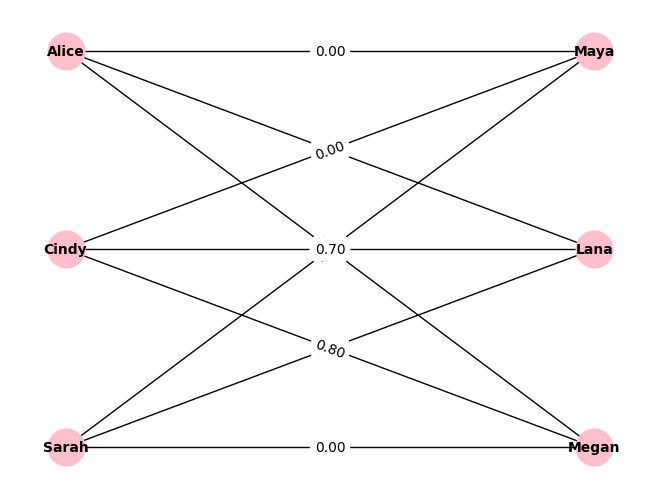

In [64]:
G = nx.Graph()
patients_nodes = [patient['name'] for patient in patients]
donors_nodes = [donor['name'] for donor in donors]
G.add_nodes_from(patients_nodes, bipartite=0, label='patient')
G.add_nodes_from(donors_nodes, bipartite=1, label='donor')

for patient in patients:
    for donor in donors:
        comp_score = compatibility_scores[(patient['name'], donor['name'])]  # Use the compatibility score from the dictionary
        G.add_edge(patient['name'], donor['name'], weight=comp_score)

pos = nx.bipartite_layout(G, patients_nodes)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, font_size=10, node_color='pink')

edge_labels = {(patient, donor): f"{G[patient][donor]['weight']:.2f}" for patient, donor in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()